# Regression

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from IPython import display

import seaborn as sns
sns.set()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using GPU" if device.type=="cuda" else "using CPU" )

# super.init ? property ? 

using GPU


## Data

In [2]:
def f(x, sigma=0):
    '''Generate data as in section 5.2 from paper'''
    noise = np.random.normal(0, np.sqrt(sigma), len(x))
    y = x + 0.3*np.sin(2*np.pi*(x + noise)) + 0.3*np.sin(4*np.pi*(x + noise)) 
    return y + noise

In [3]:
class RegressionDataset(Dataset):
    """Custom Pytorch Dataset"""

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        return (self.data[idx][0], self.data[idx][1])

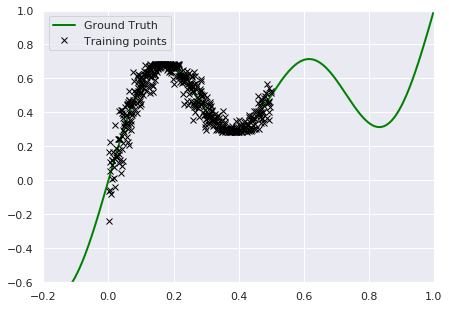

In [4]:
sigma = 0.02**2
train_size = 500
test_size = 10*train_size
bs=10

# create datasets and loaders
X_train = np.random.uniform(0, 0.5, train_size)
y_train = f(X_train, sigma=sigma)
trainset = RegressionDataset(np.vstack([X_train,y_train]).T)   
train_loader = DataLoader(trainset, batch_size=bs, shuffle=True)

X_test = np.linspace(-0.2,1, test_size)
y_test = f(X_test)
testset = RegressionDataset(np.vstack([X_test,y_test]).T)   
test_loader = DataLoader(testset, batch_size=bs, shuffle=False)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-0.2, xmax = 1.)
plt.ylim(ymin = -0.6, ymax = 1.)
plt.plot(testset.data[:,0],testset.data[:,1], color='green', linewidth=2,label="Ground Truth")
plt.plot(trainset.data[:,0],trainset.data[:,1], 'x', color='black', label='Training points')
plt.legend()
plt.show()

In [15]:
config = {
    "num_hidden_layers": 2,
    "num_hidden_units": 20,
    "batch_size": bs,
    "epochs": 10,
    "learning_rate": 0.001,
    "num_samples": 2,
    "prior_type": "gaussMixt",
    "p": 0.25,
    "sigma_p": 1.0, # ou est-ce utilise ? 
    "sigma_p1": 0.75, # torch.cuda.FloatTensor([math.exp(-0)])
    "sigma_p2": 0.1,
    "train_size": train_size,
    "test_size": len(test_loader.dataset),
    "num_batches": len(train_loader) # sigma2 = torch.cuda.FloatTensor([math.exp(-6)])
}

In [16]:
len(test_loader.dataset)

5000

## Bayes-By-Backprop

In [6]:
class Gaussian(object):
    
    def __init__(self, mu, rho, device):
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0,1) # to sample epsilon
        self.device = device
    
    def sigma(self): # to get standard deviation from rho
        return torch.log1p(torch.exp(self.rho))
    
    def sample(self): # to sample w from epsilon, mu and rho
        epsilon = self.normal.sample(self.rho.size()).to(device)
        return self.mu + self.sigma() * epsilon
    
    def log_prob(self, w): # return log q(w|theta=(mu,rho))
        return (-0.5*np.log(2 * np.pi)
                - torch.log(self.sigma())
                - ((w - self.mu) ** 2) / (2 * self.sigma() ** 2)).sum()

In [7]:
class Prior(object):
    def __init__(self, sigma1, sigma2=None, p=None, kind="gauss"):
        
        if kind not in ["gauss", "gaussMixt"]:
            raise ValueError("Unknown prior type")
            
        if kind=="gaussMixt" and (sigma2 is None or p is None):
            raise ValueError("For Mixture prior, specify p, sigma1 and sigma2")
            
        self.type=kind
            
        self.sigma1 = sigma1
        self.gaussian1 = torch.distributions.Normal(0,sigma1)
        
        if self.type=="gaussMixt":
            self.p = p
            self.sigma2 = sigma2
            self.gaussian2 = torch.distributions.Normal(0,sigma2)
    
    def log_prob(self, w): # return log(P(w)) - log of the scale mixture prior
        
        if self.type=="gauss":
            return self.gaussian1.log_prob(w).sum()
        
        else:
            prob1 = torch.exp(self.gaussian1.log_prob(w))
            prob2 = torch.exp(self.gaussian2.log_prob(w))
            return (torch.log(self.p * prob1 + (1-self.p) * prob2)).sum()

In [8]:
class BayesianLinear(nn.Module): # this form one linear layer
    def __init__(self, in_features, out_features, device, config_prior):
        super().__init__()
        
        self.in_features = in_features
        self.out_features = out_features
        self.type_prior = config_prior[0]
        self.sigma1 = config_prior[1]
        if self.type_prior=="gaussMixt":
            self.p = config_prior[-1]
            self.sigma2 = config_prior[-2]
        else:
            self.p, self.sigma2 = None, None
        
        # Weight parameters (init)
        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-0.2, 0.2))
        self.weight_rho = nn.Parameter(torch.Tensor(out_features, in_features).uniform_(-5,-4))
        self.weight = Gaussian(self.weight_mu, self.weight_rho, device)
        
        # Bias parameters (init)
        self.bias_mu = nn.Parameter(torch.Tensor(out_features).uniform_(-0.2, 0.2))
        self.bias_rho = nn.Parameter(torch.Tensor(out_features).uniform_(-5,-4))
        self.bias = Gaussian(self.bias_mu, self.bias_rho, device)
        
        # Prior distributions
        self.weight_prior = Prior(self.sigma1, self.sigma2, self.p, self.type_prior)
        self.bias_prior = Prior(self.sigma1, self.sigma2, self.p, self.type_prior)
        self.log_prior = 0
        self.log_variational_posterior = 0

    def forward(self, x, sample=False, calculate_log_probs=False):
        
        if self.training or sample: # step 1-3 article
            weight = self.weight.sample() # sample some weights
            bias = self.bias.sample() # sample some weight bias
        else:
            weight = self.weight.mu
            bias = self.bias.mu
            
        if self.training or calculate_log_probs:
            # compute log p(w)
            self.log_prior = self.weight_prior.log_prob(weight) + self.bias_prior.log_prob(bias)
            # compute log q(w|theta)
            self.log_variational_posterior = self.weight.log_prob(weight) + self.bias.log_prob(bias)
        else:
            self.log_prior, self.log_variational_posterior = 0, 0

        return F.linear(x, weight, bias)

In [9]:
class BayesianNetwork(nn.Module):
    def __init__(self, device, config_prior):
        super().__init__()
        self.l1 = BayesianLinear(1, 20, device, config_prior)
        self.l2 = BayesianLinear(20, 20, device, config_prior)
        self.l3 = BayesianLinear(20, 1, device, config_prior)
    
    def forward(self, x, sample=False):
        x = x.view(-1, 1)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = self.l3(x, sample)
        return x
    
    def log_prior(self):
        #print(self.l1.log_prior, self.l2.log_prior, self.l3.log_prior)
        return self.l1.log_prior + self.l2.log_prior + self.l3.log_prior
    
    def log_variational_posterior(self):
        return self.l1.log_variational_posterior + self.l2.log_variational_posterior + self.l2.log_variational_posterior
    
    def sample_elbo(self, x, target, device, samples, num_batches, batch_size): # ELBO = f(w,theta) (step 4)
        
        outputs = torch.zeros(samples, batch_size, 1).to(device)
        log_priors = torch.zeros(samples).to(device)
        log_variational_posteriors = torch.zeros(samples).to(device)
        
        for i in range(samples):
            
            outputs[i] = self(x, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_posteriors[i] = self.log_variational_posterior()
            
        #print(log_priors)
        log_prior = log_priors.mean()
        log_variational_posterior = log_variational_posteriors.mean()
        # !!!!!!!!!! Handle p(D|theta)
        #negative_log_likelihood = F.nll_loss(outputs.mean(0), target, size_average=False)
        #negative_log_likelihood = torch.log(torch.exp(-(target - outputs.mean(0)) ** 2 / 2e-2) / math.sqrt(2e-2 * math.pi)).sum()
        
        
        negative_log_likelihood = (-math.log(math.sqrt(2e-2 * math.pi))
                                   - ((target - outputs.mean(0)) ** 2) / 2e-2).sum()
        
        #print(num_batches)
        #print(log_variational_posterior)
        #print(log_prior)
        #print(negative_log_likelihood)
        loss = (log_variational_posterior - log_prior)/num_batches + negative_log_likelihood
        
        return loss, log_prior, log_variational_posterior, negative_log_likelihood

## Training

In [10]:
config_prior = (config["prior_type"], config["sigma_p1"], config["sigma_p2"], config["p"])
net = BayesianNetwork(device, config_prior).to(device)
optimizer = optim.Adam(net.parameters())

In [13]:
def train(net, optimizer, epoch, train_loader, device, num_batches, batch_size, samples):
    net.train()
    
    #if epoch == 0: # write initial distributions
    #    write_weight_histograms(epoch)
        
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        net.zero_grad()
        loss, log_prior, log_variational_posterior, negative_log_likelihood = net.sample_elbo(data, target, device, samples, num_batches, batch_size)
        #print(loss)
        loss.backward()
        optimizer.step()
        print(loss)
        #write_loss_scalars(epoch, batch_idx, loss, log_prior, log_variational_posterior, negative_log_likelihood)
    #write_weight_histograms(epoch+1)

In [14]:
for epoch in range(config["epochs"]):
    train(net, 
          optimizer, 
          epoch, 
          train_loader, 
          device, 
          config["num_batches"], 
          config["batch_size"], 
          config["num_samples"])

 24%|██▍       | 12/50 [00:00<00:00, 50.18it/s]

tensor(-4.2324e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.1460e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.2209e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.7733e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.2520e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.1210e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.7103e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.1710e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.1790e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.2892e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.4488e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.4695e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.5431e+08, device='cuda:0', grad_fn=<AddBackward0>)


 52%|█████▏    | 26/50 [00:00<00:00, 56.86it/s]

tensor(-4.7626e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.5681e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.7545e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.0840e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.0534e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.0317e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.9262e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.3264e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.8852e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.2846e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.9301e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.2342e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.4843e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.5820e+08, device='cuda:0', grad_fn=<AddBackward0>)


 80%|████████  | 40/50 [00:00<00:00, 60.39it/s]

tensor(-5.4786e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.7869e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.2796e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.1592e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.7695e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.1673e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.1853e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.5483e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.4789e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.7330e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.7341e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.6869e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.2200e+08, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(-7.4084e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.4512e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.6436e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.7709e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.0837e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.1611e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.8495e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.5049e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.2604e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.2130e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.8889e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.7757e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.1931e+08, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 13/50 [00:00<00:00, 60.04it/s]

tensor(-8.2821e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.4361e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.1475e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.6681e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.9361e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0147e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.2057e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.4218e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.8902e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.8716e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.3790e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.3973e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.7961e+08, device='cuda:0', grad_fn=<AddBackward0>)


 54%|█████▍    | 27/50 [00:00<00:00, 61.74it/s]

tensor(-9.5210e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.5321e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.5082e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0786e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0415e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.8578e+08, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0715e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1075e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0862e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0958e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0840e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1001e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1683e+09, device='cuda:0', grad_fn=<AddBackward0>)


 82%|████████▏ | 41/50 [00:00<00:00, 64.22it/s]

tensor(-1.0992e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0620e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1149e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2189e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2181e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1594e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1944e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2589e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4145e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2151e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2653e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4059e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2879e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2444e+09, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(-1.2484e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4767e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4355e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.3655e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2424e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.5012e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4205e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.5052e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.6204e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.3994e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.6478e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.6211e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4261e+09, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 13/50 [00:00<00:00, 61.24it/s]

tensor(-1.6464e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.7295e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.7354e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.5305e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.7131e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.8284e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.5769e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.7108e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.5757e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.7393e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.8846e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.7074e+09, device='cuda:0', grad_fn=<AddBackward0>)


 50%|█████     | 25/50 [00:00<00:00, 58.46it/s]

tensor(-1.7405e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.8807e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.6478e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.9805e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.0206e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.5810e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.8564e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.9311e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.9205e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.1114e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.8727e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.0370e+09, device='cuda:0', grad_fn=<AddBackward0>)


 76%|███████▌  | 38/50 [00:00<00:00, 59.77it/s]

tensor(-2.0399e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.1336e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.2943e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.0602e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.0246e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.1281e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.3873e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.3298e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.4143e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.3787e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.5457e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.3214e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.7635e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.4928e+09, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 7/50 [00:00<00:00, 65.88it/s]

tensor(-2.1341e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.2315e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.5677e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.5259e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.5325e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.5175e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.6102e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.4976e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.6056e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.5528e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.6548e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.8279e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.8654e+09, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 21/50 [00:00<00:00, 66.17it/s]

tensor(-2.6707e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.9555e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.8235e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.7572e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.8219e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.7838e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.0206e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.8787e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.7907e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.5470e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.3487e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.0426e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.3572e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.1137e+09, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 35/50 [00:00<00:00, 66.17it/s]

tensor(-3.4834e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.3166e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.4295e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.4253e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.6957e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.2795e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.5856e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.4180e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.4292e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.3542e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.9568e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.6410e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.3764e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.5379e+09, device='cuda:0', grad_fn=<AddBackward0>)


 98%|█████████▊| 49/50 [00:00<00:00, 66.35it/s]

tensor(-3.4242e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.1764e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.7992e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.6490e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.5061e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.0865e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.1320e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.3729e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.8535e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.4346e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.0642e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.3463e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.5043e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.4724e+09, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 7/50 [00:00<00:00, 64.34it/s]

tensor(-3.6564e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.0411e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.4629e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.7883e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.3576e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.5575e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.2417e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.7140e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.2998e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.0051e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.6309e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.9918e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.6621e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.7626e+09, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 21/50 [00:00<00:00, 64.93it/s]

tensor(-5.0269e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.1319e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.2612e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.5247e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.2065e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.2113e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.3661e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.6513e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.0184e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.5956e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.5737e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.1436e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.8277e+09, device='cuda:0', grad_fn=<AddBackward0>)


 66%|██████▌   | 33/50 [00:00<00:00, 60.53it/s]

tensor(-5.3299e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.4326e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.1956e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.5467e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.9332e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.6684e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.6813e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.7026e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.3061e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.6860e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.8184e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.2242e+09, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(-6.2456e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-5.6885e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.3887e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.2121e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.2562e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.4593e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.5691e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.0649e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.2685e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.8221e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.3505e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.7498e+09, device='cuda:0', grad_fn=<AddBackward0>)


 26%|██▌       | 13/50 [00:00<00:00, 59.98it/s]

tensor(-6.8658e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.2023e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.3076e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.1652e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.4204e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.4010e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.8449e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-6.8891e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.9325e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.3156e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.4285e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.0670e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.7253e+09, device='cuda:0', grad_fn=<AddBackward0>)


 40%|████      | 20/50 [00:00<00:00, 60.14it/s]

tensor(-8.3270e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.5323e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.8923e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.8970e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.5666e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.8603e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.6342e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.0047e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.5316e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.2115e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-7.8475e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.8111e+09, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 32/50 [00:00<00:00, 58.11it/s]

tensor(-8.2849e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.6996e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0174e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.3243e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.2439e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.8910e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.6553e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.9340e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.2794e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0152e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.6386e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-8.6934e+09, device='cuda:0', grad_fn=<AddBackward0>)


 88%|████████▊ | 44/50 [00:00<00:00, 57.37it/s]

tensor(-1.0880e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0451e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-9.4043e+09, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0513e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0150e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0016e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0240e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1345e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0312e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0943e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1033e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0295e+10, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 7/50 [00:00<00:00, 64.91it/s]

tensor(-1.0783e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0634e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1971e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0829e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0593e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1215e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1029e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0910e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1890e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1914e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1295e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2231e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.1368e+10, device='cuda:0', grad_fn=<AddBackward0>)


 38%|███▊      | 19/50 [00:00<00:00, 60.99it/s]

tensor(-1.1772e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2139e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2332e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.0859e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2055e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.3595e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2336e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.3624e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.3292e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.3175e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4088e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2050e+10, device='cuda:0', grad_fn=<AddBackward0>)


 62%|██████▏   | 31/50 [00:00<00:00, 58.66it/s]

tensor(-1.2958e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.3009e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4352e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4360e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.3028e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.2044e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4246e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4015e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4911e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.3996e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.5655e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.5363e+10, device='cuda:0', grad_fn=<AddBackward0>)


 90%|█████████ | 45/50 [00:00<00:00, 60.49it/s]

tensor(-1.6557e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4502e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4859e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.5232e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.6059e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.7185e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.6526e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.6800e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.5994e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.5981e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.5215e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.7178e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.6591e+10, device='cuda:0', grad_fn=<AddBackward0>)


 12%|█▏        | 6/50 [00:00<00:00, 56.18it/s]

tensor(-1.5408e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4227e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.7224e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.5277e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4950e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.6787e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.6767e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.6338e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.8030e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.4547e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.6051e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.8359e+10, device='cuda:0', grad_fn=<AddBackward0>)


 36%|███▌      | 18/50 [00:00<00:00, 56.42it/s]

tensor(-2.0017e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.7069e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.9730e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.8298e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.0126e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.0226e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.1064e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.9289e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.9811e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.7078e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.0738e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.8039e+10, device='cuda:0', grad_fn=<AddBackward0>)


 64%|██████▍   | 32/50 [00:00<00:00, 58.76it/s]

tensor(-1.9013e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.9497e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.1385e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.9821e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-1.9640e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.0058e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.1247e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.0010e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.1825e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.0988e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.2642e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.3689e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.1064e+10, device='cuda:0', grad_fn=<AddBackward0>)


 92%|█████████▏| 46/50 [00:00<00:00, 61.73it/s]

tensor(-2.2292e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.2801e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.2550e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.2455e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.2224e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.3755e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.3038e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.5033e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.4031e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.2555e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.2957e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.3286e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.2596e+10, device='cuda:0', grad_fn=<AddBackward0>)


 14%|█▍        | 7/50 [00:00<00:00, 64.97it/s]

tensor(-2.4243e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.3435e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.7548e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.3017e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.1973e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.7520e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.2486e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.2999e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.4225e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.7271e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.5422e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.4799e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.2939e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.6436e+10, device='cuda:0', grad_fn=<AddBackward0>)


 42%|████▏     | 21/50 [00:00<00:00, 64.68it/s]

tensor(-2.6806e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.7542e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.6895e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.8876e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.7334e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.5099e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.9046e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.7104e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.4871e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.6572e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.8498e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.9516e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.9994e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.7977e+10, device='cuda:0', grad_fn=<AddBackward0>)


 70%|███████   | 35/50 [00:00<00:00, 64.65it/s]

tensor(-3.1173e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.7537e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.8968e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.8914e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.1497e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.9719e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.9547e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.1801e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.4549e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.3009e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.3273e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.3291e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.1574e+10, device='cuda:0', grad_fn=<AddBackward0>)


  0%|          | 0/50 [00:00<?, ?it/s]

tensor(-3.3347e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-2.9332e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.3681e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.3594e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.3266e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.4922e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.5504e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.1147e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.4715e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.5089e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.7277e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.4594e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.6165e+10, device='cuda:0', grad_fn=<AddBackward0>)


 28%|██▊       | 14/50 [00:00<00:00, 64.82it/s]

tensor(-3.7119e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.3778e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.6801e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.8496e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.1205e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.5590e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.6091e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.0454e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.4356e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.7525e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.9257e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.8068e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.3705e+10, device='cuda:0', grad_fn=<AddBackward0>)


 56%|█████▌    | 28/50 [00:00<00:00, 64.74it/s]

tensor(-3.5887e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.4870e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.8334e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.4436e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.9800e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.3582e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.8899e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.0562e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.1633e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.6341e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.6528e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.3360e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.0214e+10, device='cuda:0', grad_fn=<AddBackward0>)


 84%|████████▍ | 42/50 [00:00<00:00, 64.71it/s]

tensor(-4.1263e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.3447e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.7872e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.8230e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.3938e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.2630e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-3.8430e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.4720e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.6461e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.9918e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.2989e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.2319e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.5480e+10, device='cuda:0', grad_fn=<AddBackward0>)


100%|██████████| 50/50 [00:00<00:00, 64.53it/s]

tensor(-4.3654e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.3186e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.2253e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.6910e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.7438e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.6691e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.8103e+10, device='cuda:0', grad_fn=<AddBackward0>)
tensor(-4.7864e+10, device='cuda:0', grad_fn=<AddBackward0>)


In [23]:
def test_ensemble(device):
    net.eval()
    scores = np.zeros(10+1, dtype=int)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = torch.zeros(10+1, config["batch_size"]).to(device)
            for i in range(10):
                outputs[i] = net(data, sample=True).view(-1)
            outputs[10] = net(data, sample=False).view(-1)
            scores += (target-output)
    #for index, num in enumerate(corrects):
    #    if index < TEST_SAMPLES:
    #        print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
    #    else:
    #        print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    #print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))

test_ensemble(device)

tensor([-2046.2207, -2046.7800, -2047.3396, -2047.8987, -2048.4580, -2049.0173,
        -2049.5767, -2050.1360, -2050.6953, -2051.2551], device='cuda:0')
tensor([-2052.3599, -2052.9202, -2053.4805, -2054.0410, -2054.6011, -2055.1616,
        -2055.7219, -2056.2820, -2056.8423, -2057.4026], device='cuda:0')
tensor([-2058.2322, -2058.7930, -2059.3535, -2059.9141, -2060.4746, -2061.0352,
        -2061.5959, -2062.1565, -2062.7170, -2063.2773], device='cuda:0')
tensor([-2062.4199, -2062.9802, -2063.5403, -2064.1008, -2064.6614, -2065.2212,
        -2065.7817, -2066.3418, -2066.9023, -2067.4624], device='cuda:0')
tensor([-2066.9749, -2067.5342, -2068.0938, -2068.6533, -2069.2126, -2069.7720,
        -2070.3313, -2070.8906, -2071.4500, -2072.0098], device='cuda:0')
tensor([-2075.6709, -2076.2312, -2076.7915, -2077.3521, -2077.9121, -2078.4724,
        -2079.0332, -2079.5930, -2080.1536, -2080.7141], device='cuda:0')
tensor([-2081.8169, -2082.3770, -2082.9370, -2083.4973, -2084.0576, -2084.61

tensor([-2364.0337, -2364.5933, -2365.1528, -2365.7122, -2366.2715, -2366.8306,
        -2367.3904, -2367.9497, -2368.5090, -2369.0684], device='cuda:0')
tensor([-2372.1499, -2372.7102, -2373.2708, -2373.8311, -2374.3911, -2374.9517,
        -2375.5117, -2376.0723, -2376.6326, -2377.1929], device='cuda:0')
tensor([-2377.2061, -2377.7656, -2378.3254, -2378.8853, -2379.4453, -2380.0051,
        -2380.5647, -2381.1248, -2381.6846, -2382.2444], device='cuda:0')
tensor([-2381.2915, -2381.8516, -2382.4119, -2382.9719, -2383.5320, -2384.0920,
        -2384.6521, -2385.2122, -2385.7722, -2386.3320], device='cuda:0')
tensor([-2388.7522, -2389.3120, -2389.8723, -2390.4321, -2390.9919, -2391.5520,
        -2392.1123, -2392.6719, -2393.2319, -2393.7920], device='cuda:0')
tensor([-2391.0950, -2391.6545, -2392.2141, -2392.7734, -2393.3328, -2393.8921,
        -2394.4517, -2395.0110, -2395.5703, -2396.1296], device='cuda:0')
tensor([-2398.9507, -2399.5107, -2400.0708, -2400.6313, -2401.1914, -2401.75

tensor([-2679.7649, -2680.3247, -2680.8848, -2681.4446, -2682.0044, -2682.5642,
        -2683.1240, -2683.6841, -2684.2439, -2684.8037], device='cuda:0')
tensor([-2683.8640, -2684.4236, -2684.9834, -2685.5430, -2686.1030, -2686.6628,
        -2687.2224, -2687.7820, -2688.3420, -2688.9016], device='cuda:0')
tensor([-2688.8054, -2689.3655, -2689.9255, -2690.4856, -2691.0457, -2691.6060,
        -2692.1660, -2692.7258, -2693.2859, -2693.8457], device='cuda:0')
tensor([-2693.6436, -2694.2031, -2694.7629, -2695.3228, -2695.8821, -2696.4419,
        -2697.0017, -2697.5615, -2698.1211, -2698.6809], device='cuda:0')
tensor([-2701.4050, -2701.9646, -2702.5242, -2703.0840, -2703.6436, -2704.2031,
        -2704.7629, -2705.3223, -2705.8821, -2706.4414], device='cuda:0')
tensor([-2705.8840, -2706.4441, -2707.0039, -2707.5642, -2708.1240, -2708.6841,
        -2709.2441, -2709.8040, -2710.3643, -2710.9241], device='cuda:0')
tensor([-2714.4978, -2715.0579, -2715.6184, -2716.1785, -2716.7388, -2717.29

tensor([-3101.3225, -3101.8816, -3102.4412, -3103.0005, -3103.5598, -3104.1187,
        -3104.6785, -3105.2373, -3105.7969, -3106.3562], device='cuda:0')
tensor([-3110.1536, -3110.7136, -3111.2734, -3111.8333, -3112.3933, -3112.9529,
        -3113.5125, -3114.0725, -3114.6328, -3115.1921], device='cuda:0')
tensor([-3114.5327, -3115.0925, -3115.6523, -3116.2122, -3116.7722, -3117.3318,
        -3117.8914, -3118.4512, -3119.0115, -3119.5708], device='cuda:0')
tensor([-3121.5718, -3122.1316, -3122.6912, -3123.2512, -3123.8108, -3124.3708,
        -3124.9302, -3125.4905, -3126.0500, -3126.6099], device='cuda:0')
tensor([-3126.9121, -3127.4719, -3128.0317, -3128.5918, -3129.1511, -3129.7109,
        -3130.2710, -3130.8303, -3131.3899, -3131.9500], device='cuda:0')
tensor([-3130.8328, -3131.3926, -3131.9521, -3132.5117, -3133.0715, -3133.6311,
        -3134.1907, -3134.7505, -3135.3101, -3135.8701], device='cuda:0')
tensor([-3136.5449, -3137.1042, -3137.6638, -3138.2234, -3138.7827, -3139.34

tensor([-3579.0078, -3579.5676, -3580.1272, -3580.6870, -3581.2466, -3581.8062,
        -3582.3660, -3582.9253, -3583.4849, -3584.0442], device='cuda:0')
tensor([-3586.5620, -3587.1218, -3587.6816, -3588.2419, -3588.8022, -3589.3623,
        -3589.9226, -3590.4827, -3591.0425, -3591.6028], device='cuda:0')
tensor([-3589.9419, -3590.5007, -3591.0608, -3591.6201, -3592.1797, -3592.7390,
        -3593.2988, -3593.8582, -3594.4177, -3594.9773], device='cuda:0')
tensor([-3600.7202, -3601.2800, -3601.8398, -3602.3999, -3602.9597, -3603.5200,
        -3604.0796, -3604.6396, -3605.1997, -3605.7593], device='cuda:0')
tensor([-3603.0271, -3603.5872, -3604.1467, -3604.7065, -3605.2664, -3605.8262,
        -3606.3857, -3606.9458, -3607.5054, -3608.0654], device='cuda:0')
tensor([-3607.4343, -3607.9941, -3608.5535, -3609.1128, -3609.6724, -3610.2317,
        -3610.7913, -3611.3506, -3611.9099, -3612.4695], device='cuda:0')
tensor([-3614.0247, -3614.5842, -3615.1440, -3615.7031, -3616.2629, -3616.82

tensor([-3921.4553, -3922.0151, -3922.5747, -3923.1350, -3923.6948, -3924.2544,
        -3924.8145, -3925.3745, -3925.9341, -3926.4944], device='cuda:0')
tensor([-3921.9663, -3922.5256, -3923.0850, -3923.6440, -3924.2031, -3924.7625,
        -3925.3215, -3925.8809, -3926.4402, -3926.9990], device='cuda:0')
tensor([-3932.8779, -3933.4380, -3933.9980, -3934.5581, -3935.1179, -3935.6780,
        -3936.2380, -3936.7981, -3937.3577, -3937.9185], device='cuda:0')
tensor([-3936.2466, -3936.8054, -3937.3652, -3937.9241, -3938.4834, -3939.0427,
        -3939.6021, -3940.1614, -3940.7202, -3941.2800], device='cuda:0')
tensor([-3945.9109, -3946.4709, -3947.0312, -3947.5913, -3948.1519, -3948.7117,
        -3949.2722, -3949.8325, -3950.3926, -3950.9526], device='cuda:0')
tensor([-3947.3865, -3947.9460, -3948.5054, -3949.0647, -3949.6248, -3950.1841,
        -3950.7437, -3951.3030, -3951.8623, -3952.4219], device='cuda:0')
tensor([-3955.0112, -3955.5710, -3956.1311, -3956.6904, -3957.2507, -3957.81

tensor([-4261.5044, -4262.0635, -4262.6226, -4263.1821, -4263.7417, -4264.3008,
        -4264.8604, -4265.4199, -4265.9790, -4266.5386], device='cuda:0')
tensor([-4266.2354, -4266.7944, -4267.3540, -4267.9136, -4268.4731, -4269.0322,
        -4269.5918, -4270.1509, -4270.7109, -4271.2700], device='cuda:0')
tensor([-4270.9702, -4271.5298, -4272.0889, -4272.6484, -4273.2075, -4273.7666,
        -4274.3262, -4274.8857, -4275.4448, -4276.0044], device='cuda:0')
tensor([-4278.2534, -4278.8130, -4279.3721, -4279.9321, -4280.4917, -4281.0508,
        -4281.6108, -4282.1704, -4282.7295, -4283.2896], device='cuda:0')
tensor([-4283.0239, -4283.5835, -4284.1431, -4284.7021, -4285.2622, -4285.8213,
        -4286.3813, -4286.9399, -4287.5000, -4288.0591], device='cuda:0')
tensor([-4290.4961, -4291.0557, -4291.6157, -4292.1758, -4292.7354, -4293.2954,
        -4293.8545, -4294.4150, -4294.9741, -4295.5342], device='cuda:0')
tensor([-4294.6294, -4295.1890, -4295.7485, -4296.3086, -4296.8682, -4297.42

tensor([-4595.7026, -4596.2617, -4596.8213, -4597.3809, -4597.9404, -4598.5000,
        -4599.0591, -4599.6187, -4600.1782, -4600.7383], device='cuda:0')
tensor([-4602.8394, -4603.3994, -4603.9595, -4604.5186, -4605.0791, -4605.6387,
        -4606.1982, -4606.7578, -4607.3179, -4607.8779], device='cuda:0')
tensor([-4608.5503, -4609.1104, -4609.6699, -4610.2295, -4610.7896, -4611.3496,
        -4611.9092, -4612.4692, -4613.0293, -4613.5889], device='cuda:0')
tensor([-4611.0210, -4611.5806, -4612.1401, -4612.6992, -4613.2588, -4613.8179,
        -4614.3774, -4614.9365, -4615.4961, -4616.0557], device='cuda:0')
tensor([-4625.3540, -4625.9141, -4626.4746, -4627.0342, -4627.5947, -4628.1548,
        -4628.7153, -4629.2754, -4629.8354, -4630.3955], device='cuda:0')
tensor([-4627.1450, -4627.7041, -4628.2637, -4628.8228, -4629.3828, -4629.9419,
        -4630.5015, -4631.0610, -4631.6201, -4632.1807], device='cuda:0')
tensor([-4635.2197, -4635.7798, -4636.3394, -4636.8994, -4637.4595, -4638.01